#### Some imports


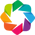

In [25]:
import numpy as np
import xarray as xr
import holoviews as hv
hv.extension('bokeh')

#### Some data (xarray.Dataset)

In [26]:
xvals = np.linspace(-5,5,256)
yvals = np.linspace(-5,5,256)
xs,ys = np.meshgrid(xvals, yvals)

def waves_image(alpha, beta):
    return np.sin(((ys/alpha)**alpha+beta)*xs)

data_vars = {
    'i1': (['y', 'x'], waves_image(1., 1.)),
    'i2': (['y', 'x'], waves_image(1., 2.)),
    'i3': (['y', 'x'], waves_image(1., 3.)),
    'i4': (['y', 'x'], waves_image(1., 4.))
}
coords = {
    'x': (['x'], xvals, {'units':'a.u.'}), 
    'y': (['y'], yvals, {'units':'a.u'})
}
xrds = xr.Dataset(data_vars=data_vars, coords=coords)
xrds

<xarray.Dataset>
Dimensions:  (x: 256, y: 256)
Coordinates:
  * x        (x) float64 -5.0 -4.961 -4.922 -4.882 -4.843 -4.804 -4.765 ...
  * y        (y) float64 -5.0 -4.961 -4.922 -4.882 -4.843 -4.804 -4.765 ...
Data variables:
    i1       (y, x) float64 0.9129 0.838 0.7424 0.6287 0.4995 0.358 0.2077 ...
    i2       (y, x) float64 0.6503 0.735 0.8095 0.8728 0.9241 0.9625 0.9877 ...
    i3       (y, x) float64 -0.544 -0.4766 -0.4063 -0.3334 -0.2585 -0.182 ...
    i4       (y, x) float64 -0.9589 -0.9693 -0.9782 -0.9856 -0.9915 -0.9958 ...

Helper function: bounds_to_text -> return *bounds* coords has a *hv.Text*

In [27]:
def bounds_to_text(bounds):
    xc = bounds[0] + (bounds[2] - bounds[0]) / 2
    yc = bounds[1] + (bounds[3] - bounds[1]) / 2
    txt = "x0: {:.2f}\ny0: {:.2f}\nx1: {:.2f}\ny1: {:.2f}".format(bounds[0], bounds[1], bounds[2], bounds[3])
    return hv.Text(xc, yc, txt, fontsize=10, halign='center', valign='center')

callable for *hv.DynamicMap*

In [28]:
def selection_callback(bounds):
    return (hv.Bounds(bounds) * bounds_to_text(bounds))

overlay *box_select* bounds on a *hv.HoloMap* containing the images stored into the *xarray.Dataset*

In [29]:
%opts Image (cmap='viridis') [width=700 height=450 toolbar='above']
images = {en:hv.Image(ed) for en, ed in xrds.data_vars.items()}
hm = hv.HoloMap(images, kdims=['img'])
box = hv.streams.BoundsXY(source=hm, bounds=(0,0,0,0))
bounds = hv.DynamicMap(selection_callback, streams=[box])
hm * bounds

:DynamicMap   [img]

overlay *box_select* bounds on a *hv.NdLayout* containing the images stored into the *xarray.Dataset*

In [30]:
%opts Image [width=500 height=250]

class ImagesSelection(object):
    def __init__(self, imgs, kdims=[]):
        self.bounds = (0,0,0,0) 
        self.dynamic_map = dict()
        self.calls = list()
        for k, i in imgs.items():
            stream = hv.streams.BoundsXY(source=i, bounds=(0,0,0,0))
            self.dynamic_map[k] = hv.DynamicMap(self.callback_factory(k), streams=[stream])
        self.bounds = hv.HoloMap(self.dynamic_map, kdims=imgs.kdims)
    
    def callback_factory(self, key):
        def callback(bounds):
            if self.bounds != bounds:
                self.bounds = bounds
                self.calls.append('{}: {}'.format(key, bounds))
                for k, dm in self.dynamic_map.items():
                    if k != key:
                        dm.event(bounds=bounds)
            return (hv.Bounds(self.bounds)* bounds_to_text(bounds))
        return callback
    
    def reset(self):
        self.bounds = (0,0,0,0) 
        for dm in self.dynamic_map.values():
            dm.event(bounds=self.bounds)
        
    def __mul__(self, hvobj):
        return hvobj * self.bounds
        
    def __rmul__(self, hvobj):
        return self.__mul__(hvobj)
    
images = hv.HoloMap({n:hv.Image(d) for n, d in xrds.data_vars.items()}, kdims=['img'])

selection = ImagesSelection(images)

hv.NdLayout(selection * images).cols(2)

:NdLayout   [img]
   :DynamicMap   []

In [32]:
selection.reset()